# Background

In this notebook we demonstrate the bias variance trade-off on toy data.

In [2]:
import os, sys
%pylab inline
plt.style.use("default")
plt.rcParams["figure.figsize"] = (12,5)

Populating the interactive namespace from numpy and matplotlib


In [6]:
def generate_dataset(x = None, n_obs = 10, noise_sd = 0.1, seed = 0):
    random.seed(seed)

    if x is None:
        x = np.linspace(0, 1, n_obs)
    else:
        n_obs = len(x)
        
    y = sin(2 * pi * x) + randn(n_obs) * noise_sd

    return x, y

def compute_features(x, n_feat = 24, feat_sd = 0.1):
    # Features are a set of Gaussian functions with means equally spaced in [0, 1]
    means = linspace(0, 1, n_feat)
    return array([0*x + 1] + [exp(-0.5 * (x - m)**2 / feat_sd**2) for m in means]).T

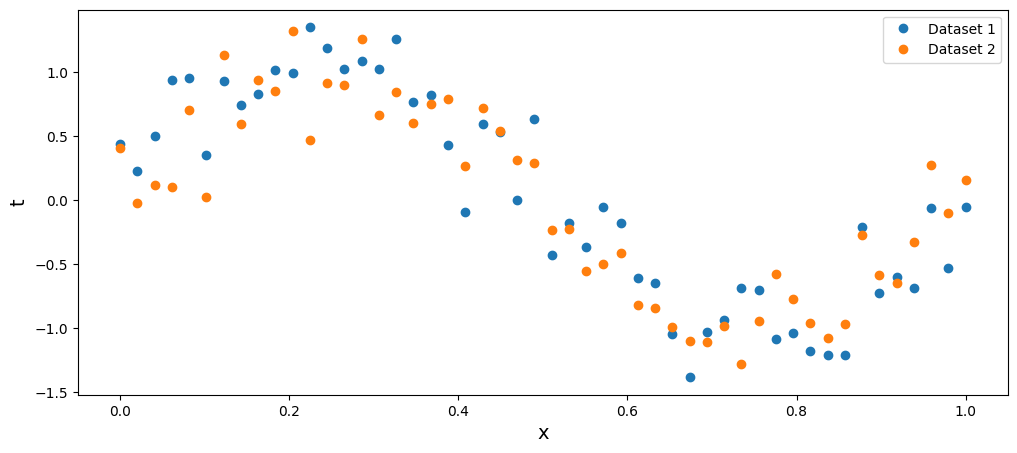

In [10]:
n_ds = 10
noise_sd = 0.25
datasets = [generate_dataset(n_obs = 50, noise_sd = noise_sd, seed = i) for i in range(n_ds)]
X, Y = zip(*datasets)
plot(X[0], Y[0], "o", label="Dataset 1")
plot(X[1], Y[1], "o", label="Dataset 2")
xlabel("x", fontsize=14); ylabel("t", fontsize=14); legend();


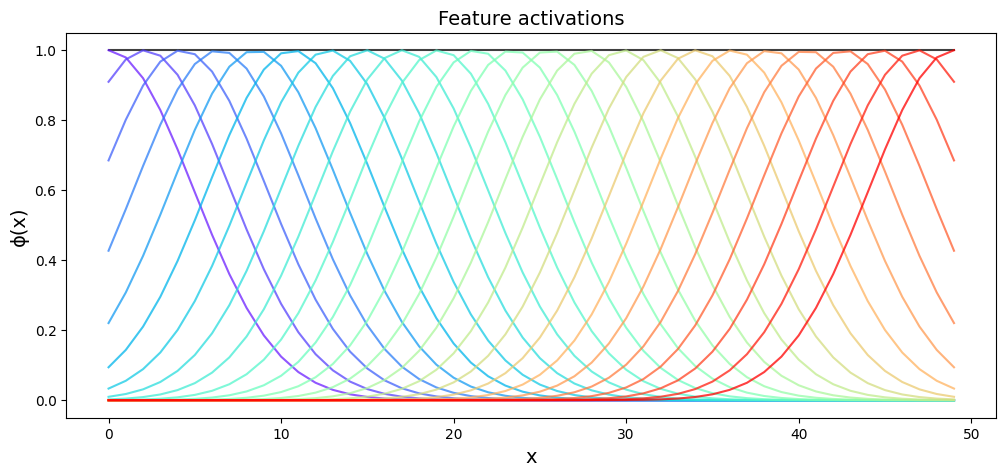

In [11]:
n_feat = 24
feat_sd = 0.1
Phi = compute_features(X[0], n_feat = n_feat, feat_sd = feat_sd) # Features are the same for all datasets
[plot(Phi_i, color="k" if i == 0 else cm.rainbow(i/n_feat), alpha=0.75) for i,Phi_i in enumerate(Phi.T)]
xlabel("x", fontsize=14); ylabel("ϕ(x)", fontsize=14); title("Feature activations", fontsize=14);

In [12]:
# Loss(w) = 1/2σ² * (y - w'ϕ(x))² + λ w'w/2
# ∇Loss(w) = -1/σ² * (y - w'ϕ(x))ϕ(x) + λw
#          = 0 -> w = (ϕ(x)'ϕ(x) + λσ²I)^-1 ϕ(x)'y
def solve(Phi, y, noise_sd=1, λ=0):
    M = Phi.shape[1]
    I = eye(M)
    G = Phi.T @ Phi + λ * noise_sd**2 * I
    w = linalg.solve(G, Phi.T @ y)
    y_hat = Phi @ w
    return w, y_hat

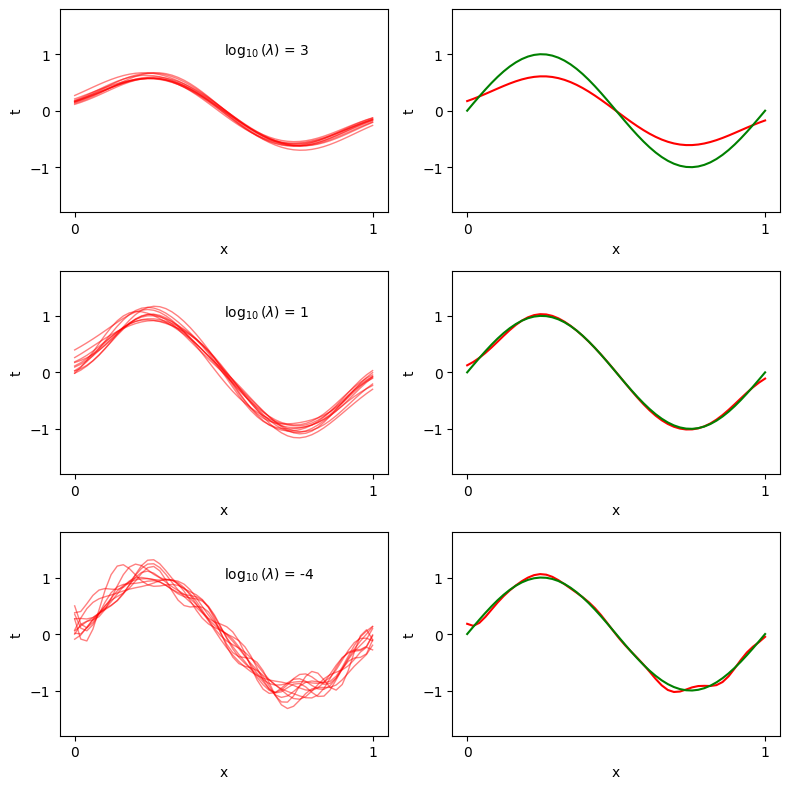

In [14]:
figure(figsize=(8, 8))
λ_vals = [5e2, 1e1, 1e-4]
for i, λ in enumerate(λ_vals):
    w_ds, y_hat_ds = zip(*[solve(Phi, y, noise_sd = noise_sd, λ = λ) for y in Y])
    y_hat_ds = array(y_hat_ds).T

    subplot(3, 2, 2*i + 1)
    plot(X[0], y_hat_ds, "r", lw=1, alpha=0.5)
    ylim(-1.8, 1.8)
    gca().set_xticks([0,1])
    xlabel("x"); ylabel("t");
    text(0.5, 1, "$\log_{10}(\\lambda)$ = " +f"{log10(λ):.1g}", ha="left")
    
    subplot(3, 2, 2*i + 2)
    plot(X[0], mean(y_hat_ds, axis=1), "r"); ylim(-1.8, 1.8)
    plot(X[0], sin(2*pi*X[0]), "g")
    gca().set_xticks([0,1])    
    xlabel("x"); ylabel("t");
tight_layout()    



In [26]:
n_train_ds = 100
X_train, Y_train = zip(*[generate_dataset(n_obs = 25,      noise_sd = noise_sd, seed = i) for i in range(n_train_ds)])
x_test,  y_test  = generate_dataset(n_obs = 1000,    noise_sd = noise_sd, seed = 1000)

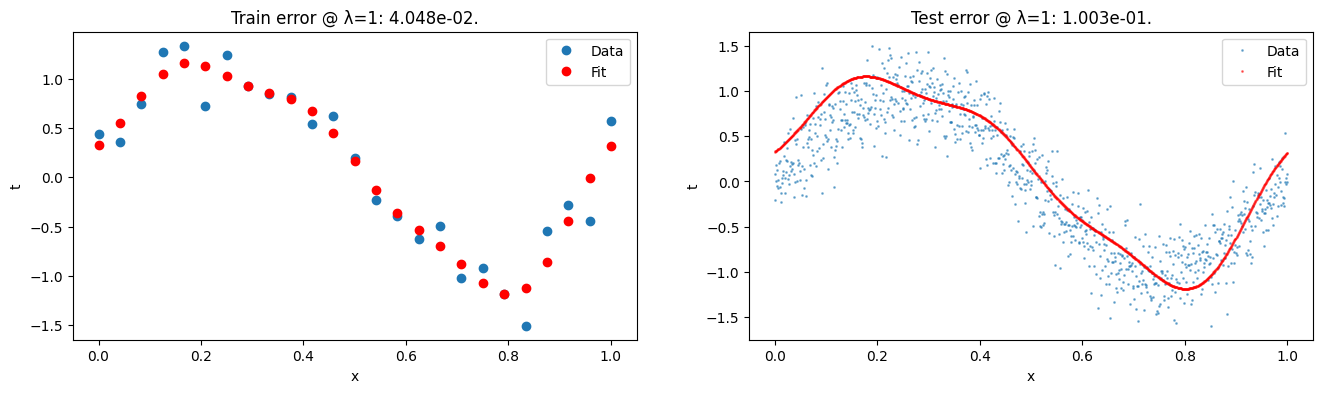

In [103]:
λ = 1
Phi = compute_features(X_train[0], n_feat = n_feat, feat_sd = feat_sd)
w, y_hat = solve(Phi, Y_train[0], noise_sd = noise_sd, λ = λ)
train_error = mean((y_hat - Y_train[0])**2)
Phi_test = compute_features(x_test, n_feat = n_feat, feat_sd = feat_sd)
y_hat_test = Phi_test @ w
test_error = mean((y_hat_test - y_test)**2)

figure(figsize=(16,4))
subplot(121)
plot(X_train[0], Y_train[0], "o", label="Data")
plot(X_train[0], y_hat, "ro", label="Fit")
xlabel("x"); ylabel("t"); legend()
title(f"Train error @ {λ=:}: {train_error:1.3e}.")
subplot(122)
title(f"Test error @ {λ=:}: {test_error:1.3e}.")
plot(x_test, y_test, "o", alpha=0.5, markersize=1, label="Data")
plot(x_test, y_hat_test, "ro", alpha=0.5, markersize=1, label="Fit")
xlabel("x"); ylabel("t"); legend()

# Compute bias-variance decomposition

In [93]:
# E_D (y_hat - y_true)^2 = E_D (y_hat - E_D y_hat + E_D y_hat - y_true)^2
# = E_D (y_hat - E_D y_hat)^2 + E_D (E_D y_hat - y_true)^2 + 2 E_D ( y_hat - E_D y_hat)(E_D y_hat - y_true)
# = E_D (y_hat - E_D y_hat)^2 + E_D (E_D y_hat - y_true)^2

bias2       = []
variance    = []
mse         = []
train_error = []
test_error  = []

Phi_test = compute_features(x_test, n_feat = n_feat, feat_sd = feat_sd)

λ_vals = logspace(-1, 3, 51)
for λ in λ_vals:
    train_error.append([])
    test_error.append([])
    mse.append([])
    y_hat_list = []
    for x_train, y_train in zip(X_train, Y_train):

        y_true = sin(2*pi*x_train)
        
        Phi = compute_features(x_train, n_feat = n_feat, feat_sd = feat_sd)

        w, y_hat = solve(Phi, y_train, noise_sd = noise_sd, λ = λ)

        y_hat_list.append(y_hat)

        train_error[-1].append(mean((y_hat - y_train)**2))
        mse[-1].append(mean((y_hat - y_true)**2))
        
        y_hat_test = Phi_test @ w
        
        test_error[-1].append(mean((y_test - y_hat_test)**2))

    # Compute averages across datasets
    mse[-1]         = mean(mse[-1])
    train_error[-1] = mean(train_error[-1])
    test_error[-1]  = mean(test_error[-1]) 
        
    y_hat_mean = mean(y_hat_list,axis=0)

    # Bias^2 = E_x E_D y_true(x) - E_D y_hat(x)
    bias = y_true - y_hat_mean # x_train is the same for all datasets, so y_true doesn't need recomputation
    bias2.append(mean(bias**2))

    # Variance = E_x E_D (y_hat(x) - E_D y_hat(x))^2
    variance.append(mean((array(y_hat_list) - y_hat_mean)**2))

mse, train_error, test_error, bias2, variance = [array(v) for v in [mse, train_error, test_error, bias2, variance]]

In [94]:
assert allclose(mse, bias2 + variance)

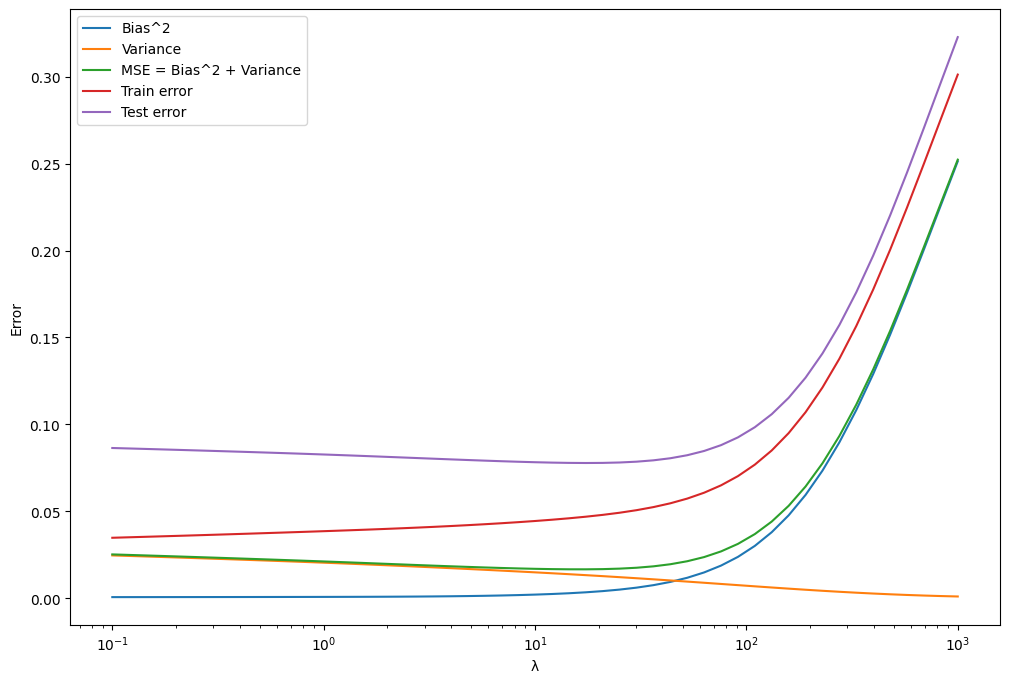

In [100]:
figure(figsize=(12,8))
semilogx(λ_vals, bias2, label="Bias^2")
semilogx(λ_vals, variance, label="Variance")
semilogx(λ_vals, mse, label="MSE = Bias^2 + Variance")
semilogx(λ_vals, train_error, label="Train error")
semilogx(λ_vals, test_error,  label="Test error")
legend()
xlabel("λ")
ylabel("Error");